In [1]:
import os
import sys
import numpy as np
import pyfits
from astropy.io import fits
import gt_apps as my_apps
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
from matplotlib.pyplot import figure
%matplotlib inline

In [2]:
infile = 'weeklyFT2/FERMI_POINTING_PRELIM_562_2019066_2019073_00.fits'
baseName = '_MW562_pm50_b_p02'
cubeName = 'ltCube/ltcube'+baseName+'.fits'
mapName = 'expCube/expCube'+baseName+'.fits'
my_apps.expCube['evfile'] = ''
my_apps.expCube['evtable'] = 'EVENTS'
my_apps.expCube['scfile'] = infile
my_apps.expCube['outfile'] = cubeName
my_apps.expCube['zmax'] = 100
my_apps.expCube['dcostheta'] = 0.025
my_apps.expCube['binsz'] = 1
my_apps.expCube['tmin'] = 'INDEF'
my_apps.expCube['tmax'] = 'INDEF'
my_apps.expCube['chatter'] = 4
#if not os.path.isfile(cubeName):
#    my_apps.expCube.run()
#else:
#    print "Exposure Cube file "+cubeName+" exists. Continuing..."

# Create an all-sky exposure map from the counts cube
my_apps.gtexpcube2['cmap'] = 'none'
my_apps.gtexpcube2['infile'] = cubeName
my_apps.gtexpcube2['outfile'] = mapName
my_apps.gtexpcube2['evtype'] = 'INDEF'
my_apps.gtexpcube2['irfs'] = 'P8R3_SOURCE_V2'
my_apps.gtexpcube2['nxpix'] = 1800
my_apps.gtexpcube2['nypix'] = 900
my_apps.gtexpcube2['binsz'] = 1
my_apps.gtexpcube2['coordsys'] = 'CEL'
my_apps.gtexpcube2['xref'] = 0
my_apps.gtexpcube2['yref'] = 0 
my_apps.gtexpcube2['axisrot'] = 0
my_apps.gtexpcube2['proj'] = 'AIT'
my_apps.gtexpcube2['ebinalg'] = 'LOG'
my_apps.gtexpcube2['emin'] = 100
my_apps.gtexpcube2['emax'] = 200000
my_apps.gtexpcube2['enumbins'] = 1
my_apps.gtexpcube2['ebinfile'] = 'NONE'
my_apps.gtexpcube2['chatter'] = '4'

if not os.path.isfile(mapName):
    my_apps.gtexpcube2.run()
else:
    print "Exposure Map file "+mapName+" exists. Continuing..."

# Now combine the two layers of the all-sky exposure cube into a single image.

Exposure Map file expCube/expCube_MW562_pm50_b_p02.fits exists. Continuing...


In [24]:
##### stackedExpMap = np.zeros(shape=cubeData[0].shape)
expCubeFile = 'expCube/expCube'+baseName+'.fits'
cubeFile = fits.open(expCubeFile)
cubeData = cubeFile['Primary'].data
stackedExpMap = np.sum([cubeData[0],cubeData[1]], axis=0)
expMapFile = 'expMap/expMap'+baseName+'.fits'
hduExpMap = fits.PrimaryHDU(stackedExpMap)
if not os.path.isfile(expMapFile):
    hduExpMap.writeto(expMapFile, overwrite=True)
else:
    print "Exposure Map file "+expMapFile+" exists. Continuing..."

Exposure Map file expMap/expMap_MW562_pm50_b_p02.fits exists. Continuing...


In [4]:
# Add layers of exposure map into a single layer to get total exposure
#for interval in intervals:
expCubeFile = 'expCube/expCube'+baseName+'.fits'
cubeFile = fits.open(expCubeFile)
cubeData = cubeFile['Primary'].data
expMapfile = 'expMap/expMap'+baseName+'.fits'
mapFile = fits.open(expMapfile)
mapData = mapFile['Primary'].data
print "Mean exposure of ExpMap",expMapfile,str(('Mean:',np.mean(mapData)))

Mean exposure of ExpMap expMap/expMap_MW562_pm50_b_p02.fits ('Mean:', 647740.31)


In [5]:
# The following code comes from Julie's notebook shared in the #observing_strategies Slack channel

#this expmap fully covers the sky, so the zero values can be used to make a selection of the
#valid (i.e. filled) parts of the expmap. it is in aitoff projection
expcube_hdu_all = pyfits.open('expMap/expMap_MW562_pm50_b_p02.fits')
selection = expcube_hdu_all[0].data[0]>0 #true for valid part of aitoff projection, false otherwise

In [6]:
# Load the data, i.e. the exposure maps
expcube_hdu_2orbit_sine_bm40 = pyfits.open('expMap/expMap_MW558_mod50_b_m40.fits')
expcube_hdu_2orbit_sine_bm35 = pyfits.open('expMap/expMap_MW558_mod50_b_m35.fits')
expcube_hdu_2orbit_sine_bm29 = pyfits.open('expMap/expMap_MW559_mod50_b_m29.fits')
expcube_hdu_2orbit_pm50_bp12= pyfits.open('expMap/expMap_MW562_pm50_b_p12.fits')
expcube_hdu_2orbit_pm50_bp07= pyfits.open('expMap/expMap_MW562_pm50_b_p07.fits')
expcube_hdu_2orbit_pm50_bp02= pyfits.open('expMap/expMap_MW562_pm50_b_p02.fits')
expcube_hdu_2orbit_50_60_bp14 = pyfits.open('expMap/expMap_MW560_50_60_b_p14.fits')
expcube_hdu_2orbit_50_60_bp18 = pyfits.open('expMap/expMap_MW561_50_60_b_p18.fits')

In [7]:
#this expmap fully covers the sky, so the zero values can be used to make a selection of the
#valid (i.e. filled) parts of the expmap. it is in aitoff projection
selection = expcube_hdu_2orbit_pm50_bp02[0].data>0 #true for valid part of aitoff projection, false otherwise
nonzero = expcube_hdu_2orbit_pm50_bp02[0].data[selection] > 0 #reference map has exposure in all pixels
print "Number of non-zero pixels:",np.count_nonzero(nonzero)

Number of non-zero pixels: 41252


In [8]:
# say that we have exposure if it is 50% of the mean, divide by number of ref pixels 
mean_2orbit_sine_bm40 = expcube_hdu_2orbit_sine_bm40[0].data[selection].mean()
nonzero_2orbit_sine_bm40 = expcube_hdu_2orbit_sine_bm40[0].data[selection] > mean_2orbit_sine_bm40 *0.5
#print np.count_nonzero(nonzero_2orbit_sine_bm40)
mean_2orbit_sine_bm35 = expcube_hdu_2orbit_sine_bm35[0].data[selection].mean()
nonzero_2orbit_sine_bm35 = expcube_hdu_2orbit_sine_bm35[0].data[selection] > mean_2orbit_sine_bm35 *0.5
#print np.count_nonzero(nonzero_2orbit_sine_bm35)
mean_2orbit_sine_bm29 = expcube_hdu_2orbit_sine_bm29[0].data[selection].mean()
nonzero_2orbit_sine_bm29 = expcube_hdu_2orbit_sine_bm29[0].data[selection] > mean_2orbit_sine_bm29 *0.5
#print np.count_nonzero(nonzero_2orbit_sine_bm29)

mean_2orbit_pm50_bp12 = expcube_hdu_2orbit_pm50_bp12[0].data[selection].mean()
nonzero_2orbit_pm50_bp12 = expcube_hdu_2orbit_pm50_bp12[0].data[selection] > mean_2orbit_pm50_bp12 *0.5
#print np.count_nonzero(nonzero_2orbit_pm50_bp12)
mean_2orbit_pm50_bp07 = expcube_hdu_2orbit_pm50_bp07[0].data[selection].mean()
nonzero_2orbit_pm50_bp07 = expcube_hdu_2orbit_pm50_bp07[0].data[selection] > mean_2orbit_pm50_bp07 *0.5
#print np.count_nonzero(nonzero_2orbit_pm50_bp07)
mean_2orbit_pm50_bp02 = expcube_hdu_2orbit_pm50_bp02[0].data[selection].mean()
nonzero_2orbit_pm50_bp02 = expcube_hdu_2orbit_pm50_bp02[0].data[selection] > mean_2orbit_pm50_bp02 *0.5
#print np.count_nonzero(nonzero_2orbit_pm50_bp02)

mean_2orbit_50_60_bp18 = expcube_hdu_2orbit_50_60_bp18[0].data[selection].mean()
nonzero_2orbit_50_60_bp18 = expcube_hdu_2orbit_50_60_bp18[0].data[selection] > mean_2orbit_50_60_bp18 *0.5
#print np.count_nonzero(nonzero_2orbit_50_60_bp18)
mean_2orbit_50_60_bp14 = expcube_hdu_2orbit_50_60_bp14[0].data[selection].mean()
nonzero_2orbit_50_60_bp14 = expcube_hdu_2orbit_50_60_bp14[0].data[selection] > mean_2orbit_50_60_bp14 *0.5
#print np.count_nonzero(nonzero_2orbit_50_60_bp14)

In [9]:
#fraction of sky pixels exposed
print('Fraction sky exposed 2-orbit mod-sine, beta = -40: ' + repr(float(np.count_nonzero(nonzero_2orbit_sine_bm40))/float(np.count_nonzero(nonzero))))
#print('Fraction sky exposed day sine: ' + repr(float(np.count_nonzero(nonzero_day_sine))/float(np.count_nonzero(nonzero))))
print('Fraction sky exposed 2-orbit +/-50, beta = +12: ' + repr(float(np.count_nonzero(nonzero_2orbit_pm50_bp12))/float(np.count_nonzero(nonzero))))
#print('Fraction sky exposed day +/- 50 : ' + repr(float(np.count_nonzero(nonzero_day_pm50))/float(np.count_nonzero(nonzero))))
print('Fraction sky exposed 2-orbit +50/-60, beta = +18: ' + repr(float(np.count_nonzero(nonzero_2orbit_50_60_bp18))/float(np.count_nonzero(nonzero))))

Fraction sky exposed 2-orbit mod-sine, beta = -40: 0.80747600116358
Fraction sky exposed 2-orbit +/-50, beta = +12: 1.0
Fraction sky exposed 2-orbit +50/-60, beta = +18: 0.8504314942305827


Text(0.5,0.98,u'2-orbit modified sine, beta = -40')

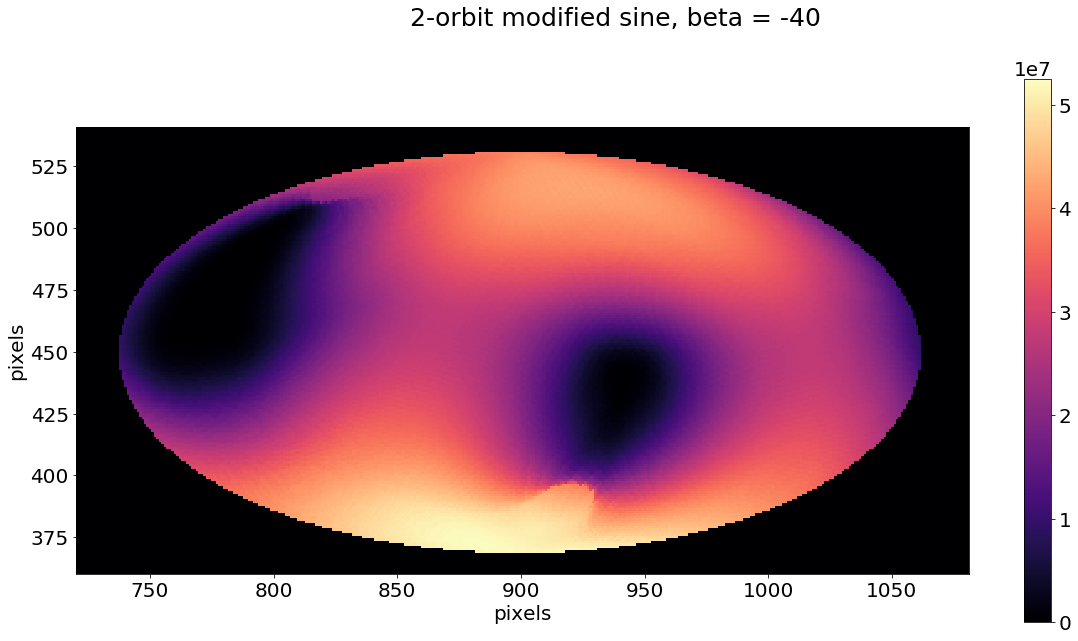

In [64]:
expmap_data = expcube_hdu_2orbit_sine_bm40[0].data
plt.imshow(expmap_data, cmap='magma')
plt.xlabel('pixels', fontsize=20)
plt.ylabel('pixels', fontsize=20)
plt.xlim(720, 1081)
plt.ylim(360,541)
plt.rcParams['figure.figsize'] = [20, 10]
plt.colorbar()
plt.suptitle('2-orbit modified sine, beta = -40', fontsize=25)

Total number of pixels: 41252
Total number of zero-value pixels: 613
Fraction of sky with zero coverage: 0.0148598855813
Fraction sky exposed: 0.80747600116358


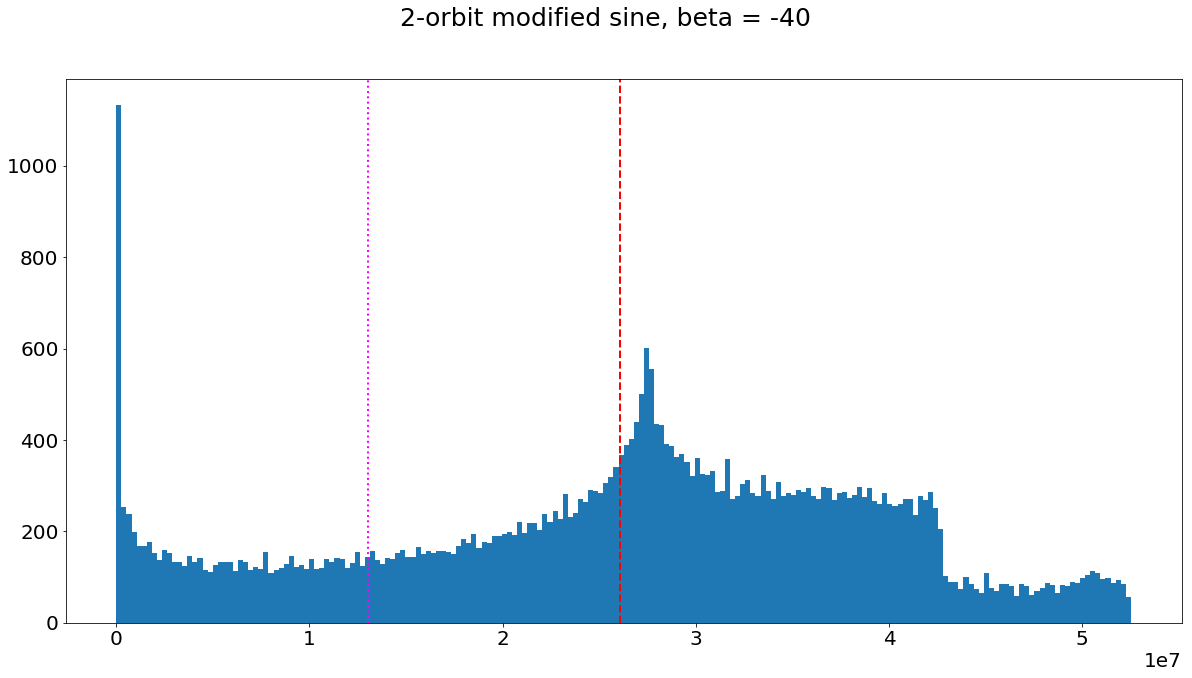

In [75]:
NBINS = 200
hist_data = expcube_hdu_2orbit_sine_bm40[0].data[selection].flatten()
print 'Total number of pixels:',len(hist_data)
num_zeros = (hist_data < 1).sum()
print 'Total number of zero-value pixels:',num_zeros
zero_fraction = float((num_zeros)/float(len(hist_data)))
print "Fraction of sky with zero coverage: "+str(zero_fraction)
print('Fraction sky exposed: ' + repr(float(np.count_nonzero(nonzero_2orbit_sine_bm40))/float(np.count_nonzero(nonzero))))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
#rcParams['figure.figsize'] = 20, 10
plt.axvline(x=mean_2orbit_sine_bm40, color='red', linewidth=2, linestyle='--')
plt.axvline(x=mean_2orbit_sine_bm40/2, color='magenta', linewidth=2, linestyle=':')
plt.suptitle('2-orbit modified sine, beta = -40', fontsize=25)
plt.hist(hist_data, NBINS)
plt.show()

Text(0.5,0.98,u'2-orbit modified sine, beta = -35')

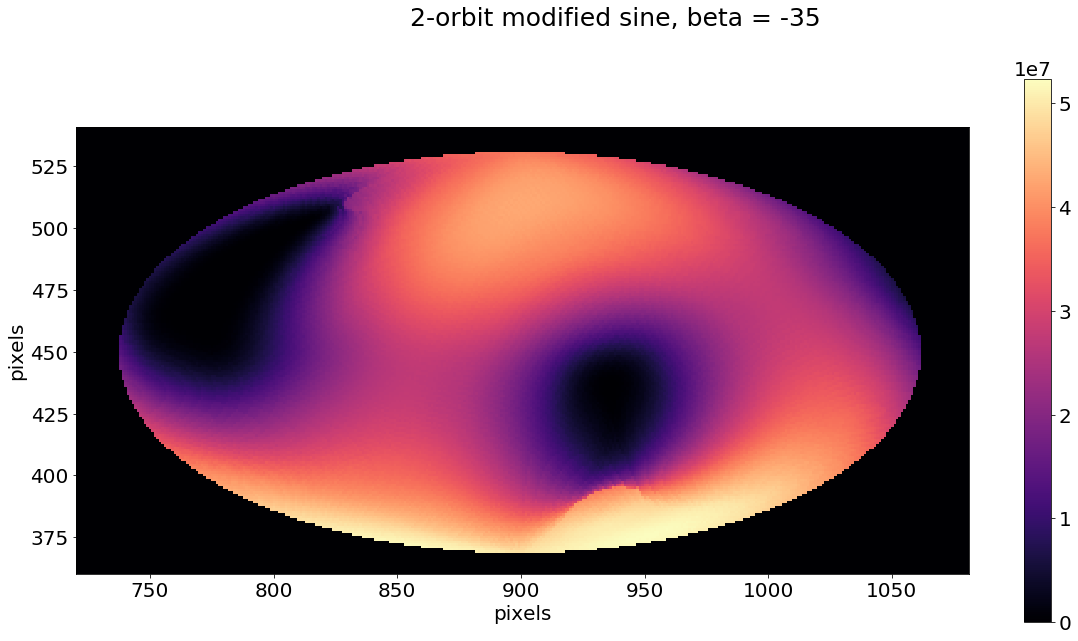

In [66]:
expmap_data = expcube_hdu_2orbit_sine_bm35[0].data
plt.imshow(expmap_data, cmap='magma')
plt.xlabel('pixels', fontsize=20)
plt.ylabel('pixels', fontsize=20)
plt.xlim(720, 1081)
plt.ylim(360,541)
plt.rcParams['figure.figsize'] = [20, 10]
plt.colorbar()
plt.suptitle('2-orbit modified sine, beta = -35', fontsize=25)

Total number of pixels: 41252
Total number of zero-value pixels: 625
Fraction of sky with zero coverage: 0.0151507805682
Fraction sky exposed: 0.8072093474255794


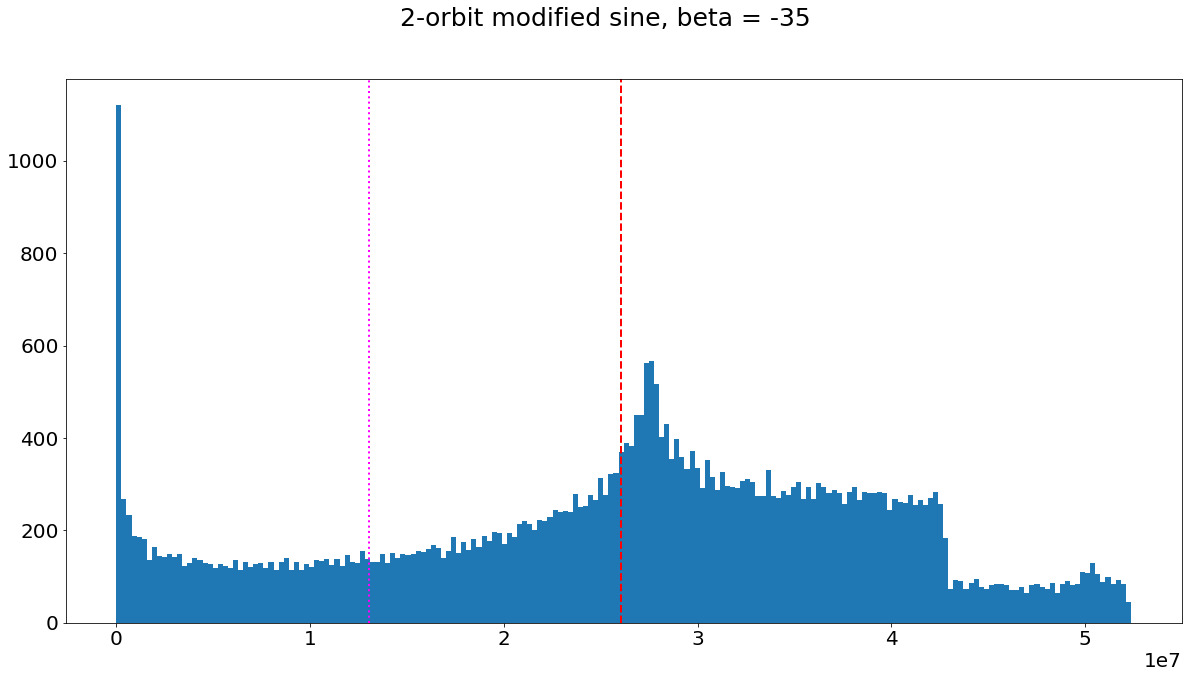

In [11]:
hist_data = expcube_hdu_2orbit_sine_bm35[0].data[selection].flatten()
print 'Total number of pixels:',len(hist_data)
num_zeros = (hist_data < 1).sum()
print 'Total number of zero-value pixels:',num_zeros
zero_fraction = float((num_zeros)/float(len(hist_data)))
print "Fraction of sky with zero coverage: "+str(zero_fraction)
print('Fraction sky exposed: ' + repr(float(np.count_nonzero(nonzero_2orbit_sine_bm35))/float(np.count_nonzero(nonzero))))
plt.axvline(x=mean_2orbit_sine_bm29, color='red', linewidth=2, linestyle='--')
plt.axvline(x=mean_2orbit_sine_bm29/2, color='magenta', linewidth=2, linestyle=':')
plt.suptitle('2-orbit modified sine, beta = -35', fontsize=25)
plt.hist(hist_data, NBINS)
plt.show()

Text(0.5,0.98,u'2-orbit modified sine, beta = -29')

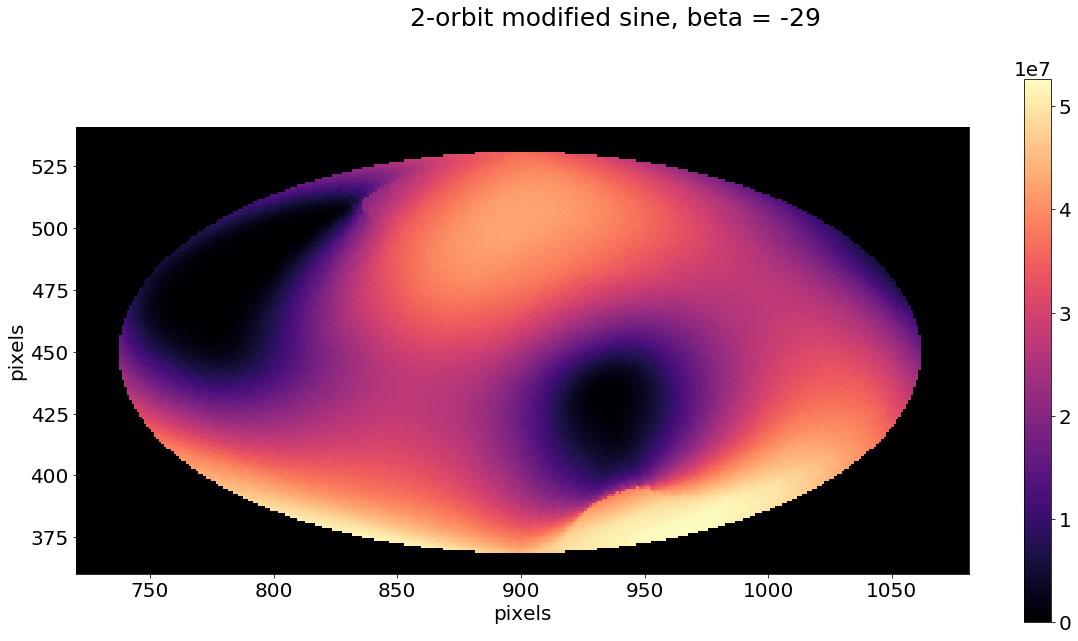

In [67]:
expmap_data = expcube_hdu_2orbit_sine_bm29[0].data
plt.imshow(expmap_data, cmap='magma')
plt.xlabel('pixels', fontsize=20)
plt.ylabel('pixels', fontsize=20)
plt.xlim(720, 1081)
plt.ylim(360,541)
plt.rcParams['figure.figsize'] = [20, 10]
plt.colorbar()
plt.suptitle('2-orbit modified sine, beta = -29', fontsize=25)

Total number of pixels: 41252
Total number of zero-value pixels: 616
Fraction of sky with zero coverage: 0.014932609328
Fraction sky exposed: 0.8075972074081257


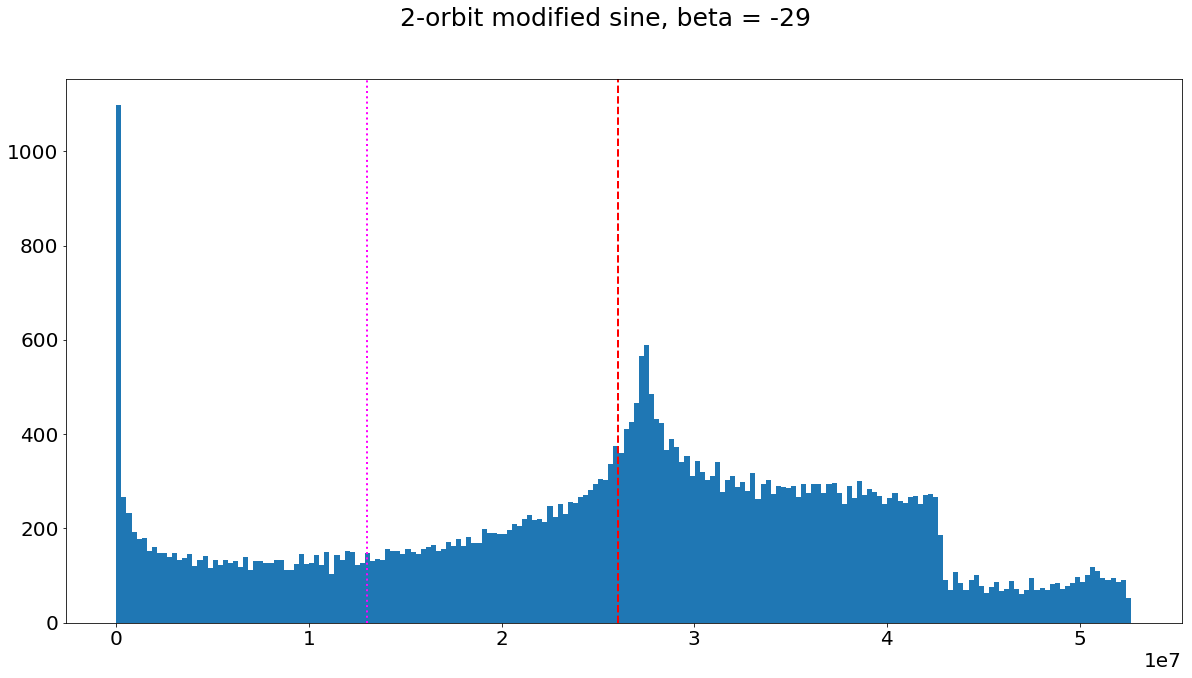

In [12]:
hist_data = expcube_hdu_2orbit_sine_bm29[0].data[selection].flatten()
print 'Total number of pixels:',len(hist_data)
num_zeros = (hist_data < 1).sum()
print 'Total number of zero-value pixels:',num_zeros
zero_fraction = float((num_zeros)/float(len(hist_data)))
print "Fraction of sky with zero coverage: "+str(zero_fraction)
print('Fraction sky exposed: ' + repr(float(np.count_nonzero(nonzero_2orbit_sine_bm29))/float(np.count_nonzero(nonzero))))
plt.axvline(x=mean_2orbit_sine_bm29, color='red', linewidth=2, linestyle='--')
plt.axvline(x=mean_2orbit_sine_bm29/2, color='magenta', linewidth=2, linestyle=':')
plt.suptitle('2-orbit modified sine, beta = -29', fontsize=25)
plt.hist(hist_data, NBINS)
plt.show()

Text(0.5,0.98,u'2-orbit asymmetric profile, beta = +18')

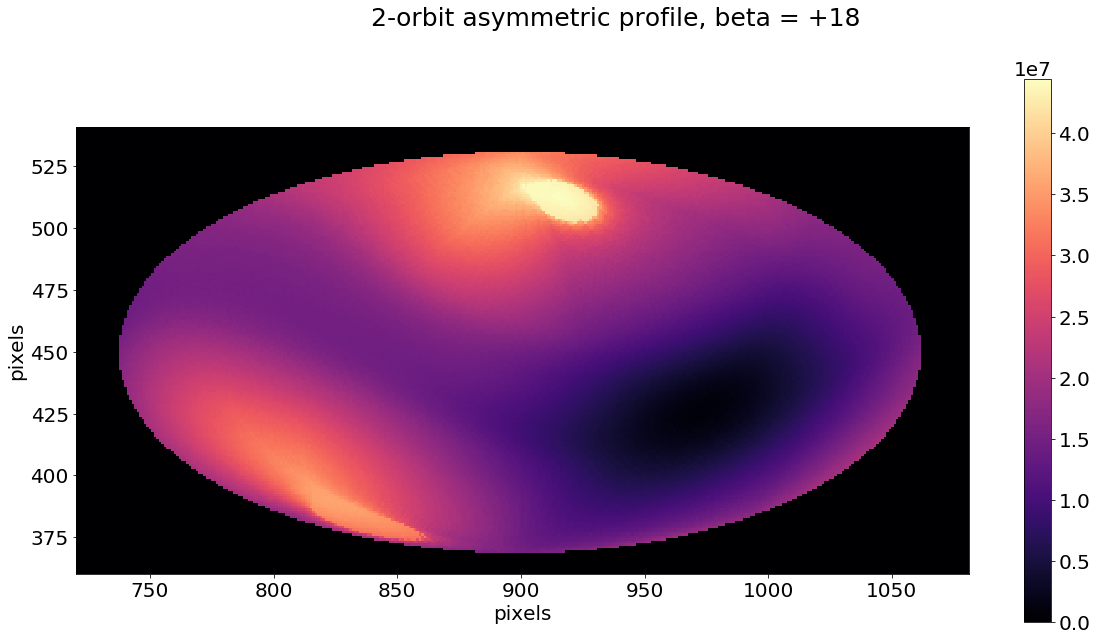

In [68]:
expmap_data = expcube_hdu_2orbit_50_60_bp18[0].data
plt.imshow(expmap_data, cmap='magma')
plt.xlabel('pixels', fontsize=20)
plt.ylabel('pixels', fontsize=20)
plt.xlim(720, 1081)
plt.ylim(360,541)
plt.rcParams['figure.figsize'] = [20, 10]
plt.colorbar()
plt.suptitle('2-orbit asymmetric profile, beta = +18', fontsize=25)

Total number of pixels: 41252
Total number of zero-value pixels: 0
Fraction of sky with zero coverage: 0.0
Fraction sky exposed: 0.8504314942305827


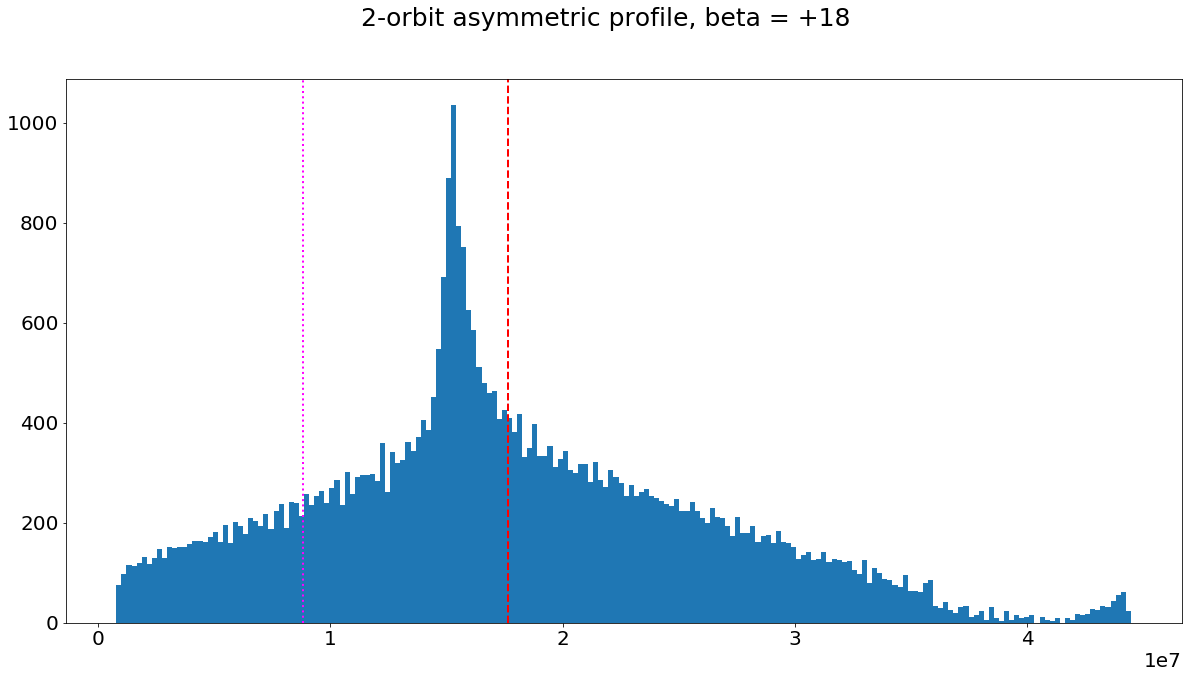

In [13]:
hist_data = expcube_hdu_2orbit_50_60_bp18[0].data[selection].flatten()
print 'Total number of pixels:',len(hist_data)
num_zeros = (hist_data < 1).sum()
print 'Total number of zero-value pixels:',num_zeros
zero_fraction = float((num_zeros)/float(len(hist_data)))
print "Fraction of sky with zero coverage: "+str(zero_fraction)
print('Fraction sky exposed: ' + repr(float(np.count_nonzero(nonzero_2orbit_50_60_bp18))/float(np.count_nonzero(nonzero))))
plt.axvline(x=mean_2orbit_50_60_bp18, color='red', linewidth=2, linestyle='--')
plt.axvline(x=mean_2orbit_50_60_bp18/2, color='magenta', linewidth=2, linestyle=':')
plt.suptitle('2-orbit asymmetric profile, beta = +18', fontsize=25)
plt.hist(hist_data, NBINS)
plt.show()

Text(0.5,0.98,u'2-orbit asymmetric profile, beta = +14')

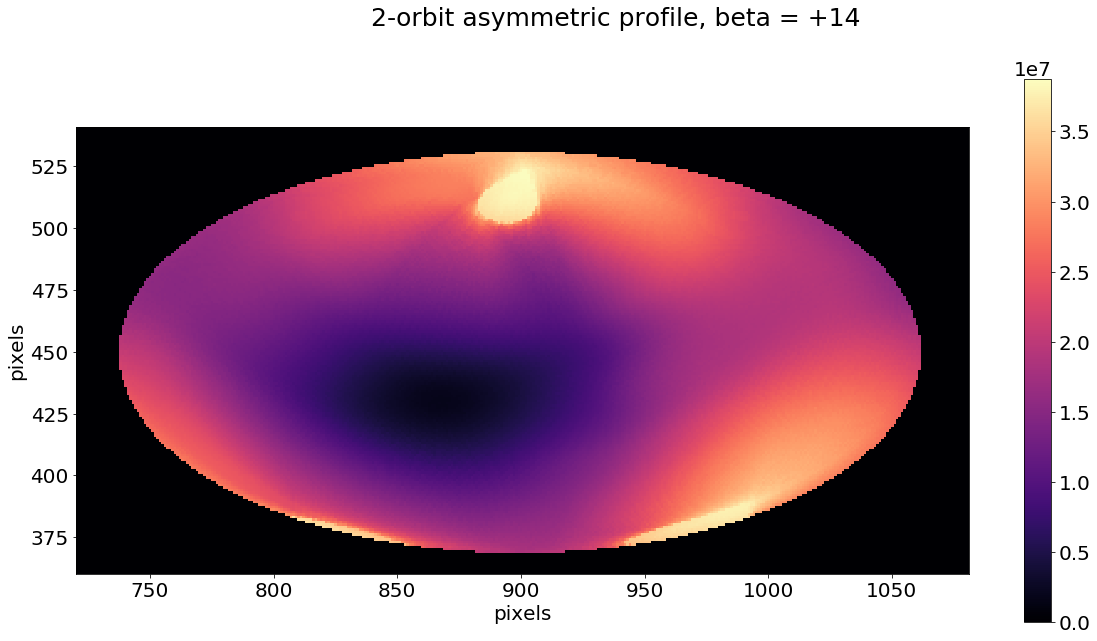

In [69]:
expmap_data = expcube_hdu_2orbit_50_60_bp14[0].data
plt.imshow(expmap_data, cmap='magma')
plt.xlabel('pixels', fontsize=20)
plt.ylabel('pixels', fontsize=20)
plt.xlim(720, 1081)
plt.ylim(360,541)
plt.rcParams['figure.figsize'] = [20, 10]
plt.colorbar()
plt.suptitle('2-orbit asymmetric profile, beta = +14', fontsize=25)

Total number of pixels: 41252
Total number of zero-value pixels: 0
Fraction of sky with zero coverage: 0.0
Fraction sky exposed: 0.8622127412004267


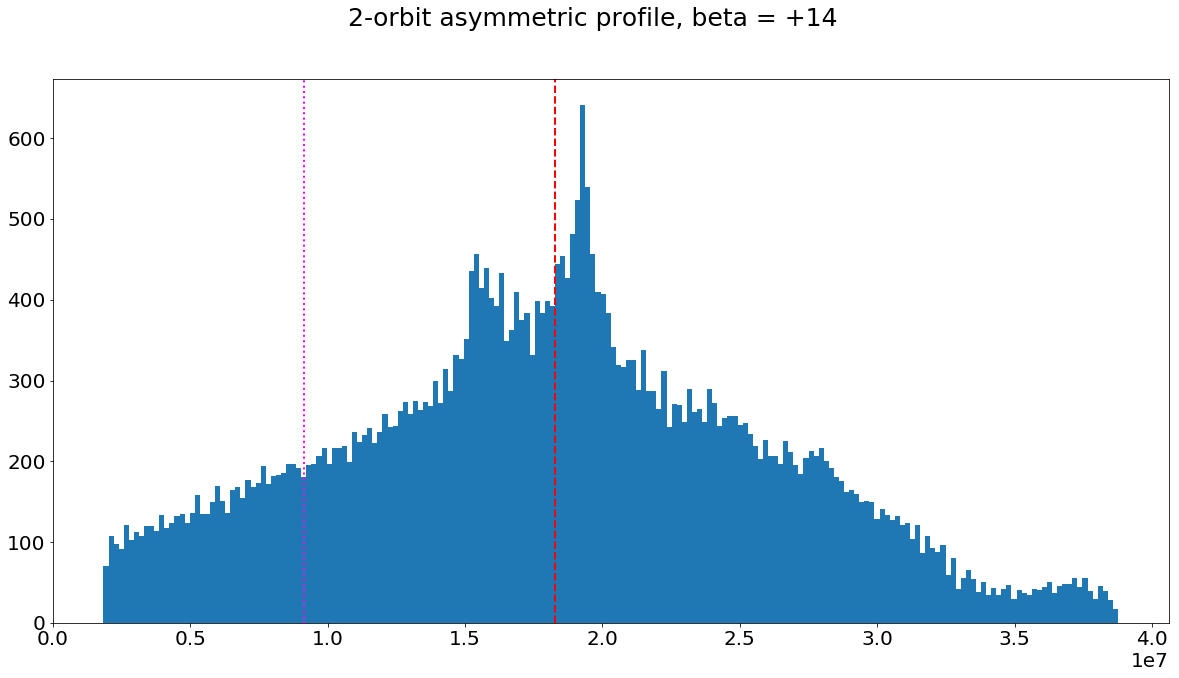

In [14]:
hist_data = expcube_hdu_2orbit_50_60_bp14[0].data[selection].flatten()
print 'Total number of pixels:',len(hist_data)
num_zeros = (hist_data < 1).sum()
print 'Total number of zero-value pixels:',num_zeros
zero_fraction = float((num_zeros)/float(len(hist_data)))
print "Fraction of sky with zero coverage: "+str(zero_fraction)
print('Fraction sky exposed: ' + repr(float(np.count_nonzero(nonzero_2orbit_50_60_bp14))/float(np.count_nonzero(nonzero))))
plt.axvline(x=mean_2orbit_50_60_bp14, color='red', linewidth=2, linestyle='--')
plt.axvline(x=mean_2orbit_50_60_bp14/2, color='magenta', linewidth=2, linestyle=':')
plt.suptitle('2-orbit asymmetric profile, beta = +14', fontsize=25)
plt.hist(hist_data, NBINS)
plt.show()

Text(0.5,0.98,u'2-orbit +-50 profile, beta = +12')

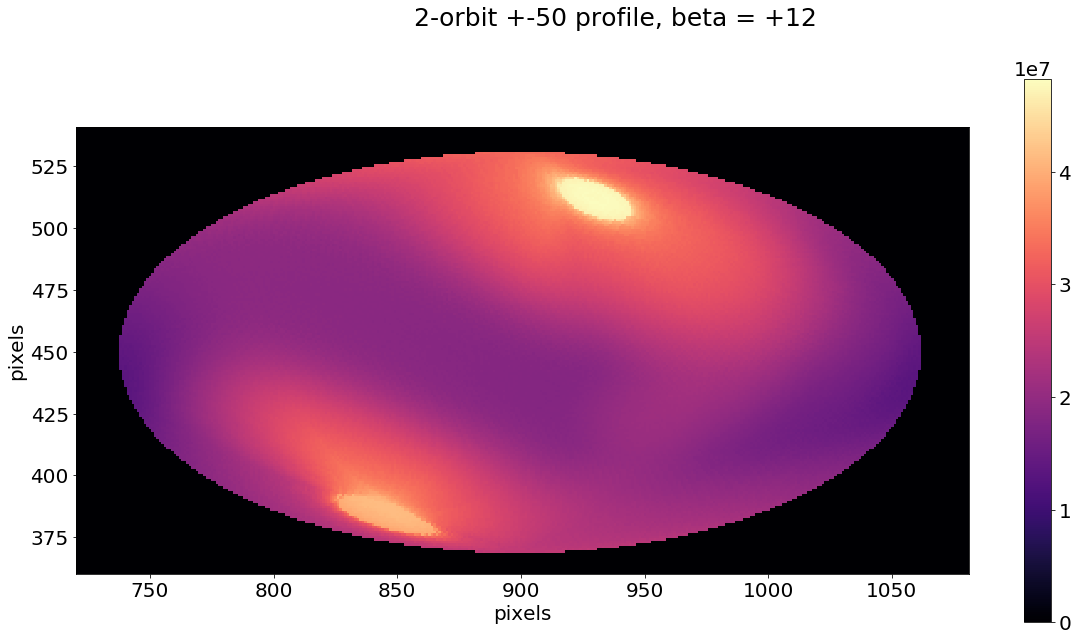

In [70]:
expmap_data = expcube_hdu_2orbit_pm50_bp12[0].data
plt.imshow(expmap_data, cmap='magma')
plt.xlabel('pixels', fontsize=20)
plt.ylabel('pixels', fontsize=20)
plt.xlim(720, 1081)
plt.ylim(360,541)
plt.rcParams['figure.figsize'] = [20, 10]
plt.colorbar()
plt.suptitle('2-orbit +-50 profile, beta = +12', fontsize=25)

Total number of pixels: 41252
Total number of zero-value pixels: 0
Fraction of sky with zero coverage: 0.0
Fraction sky exposed: 1.0


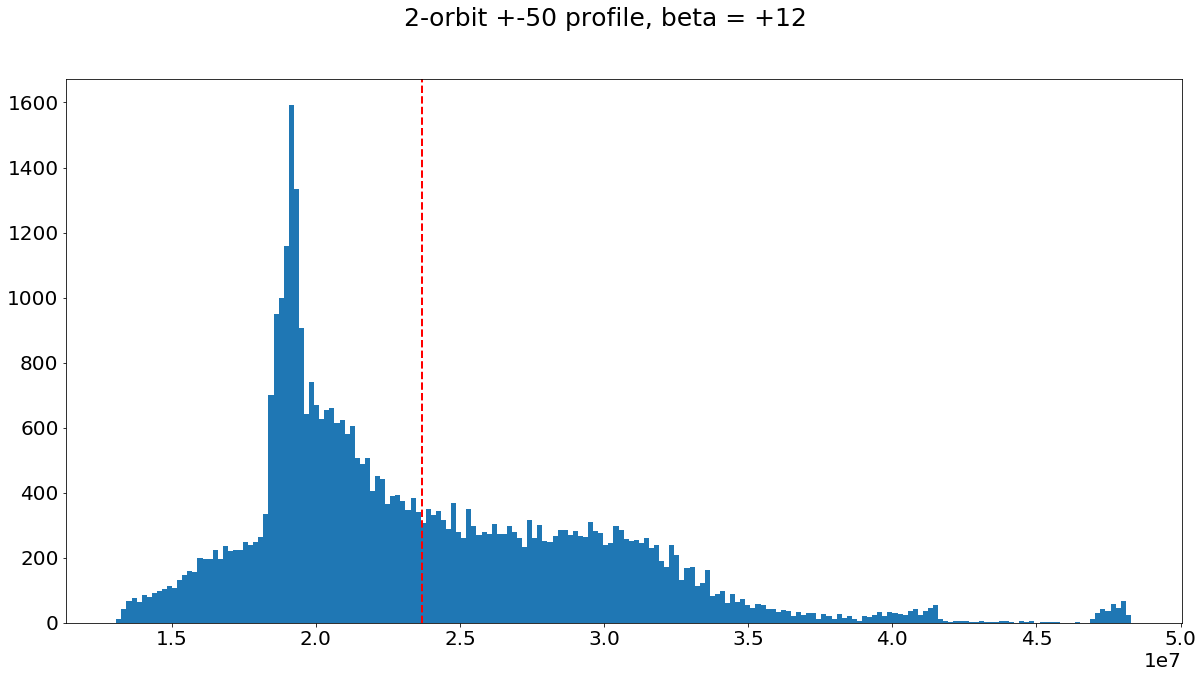

In [15]:
hist_data = expcube_hdu_2orbit_pm50_bp12[0].data[selection].flatten()
print 'Total number of pixels:',len(hist_data)
num_zeros = (hist_data < 1).sum()
print 'Total number of zero-value pixels:',num_zeros
zero_fraction = float((num_zeros)/float(len(hist_data)))
print "Fraction of sky with zero coverage: "+str(zero_fraction)
print('Fraction sky exposed: ' + repr(float(np.count_nonzero(nonzero_2orbit_pm50_bp12))/float(np.count_nonzero(nonzero))))
plt.axvline(x=mean_2orbit_pm50_bp12, color='red', linewidth=2, linestyle='--')
#plt.axvline(x=mean_2orbit_pm50_bp12/2, color='magenta', linewidth=2, linestyle=':')
plt.suptitle('2-orbit +-50 profile, beta = +12', fontsize=25)
plt.hist(hist_data, NBINS)
plt.show()

Text(0.5,0.98,u'2-orbit +-50 profile, beta = +07')

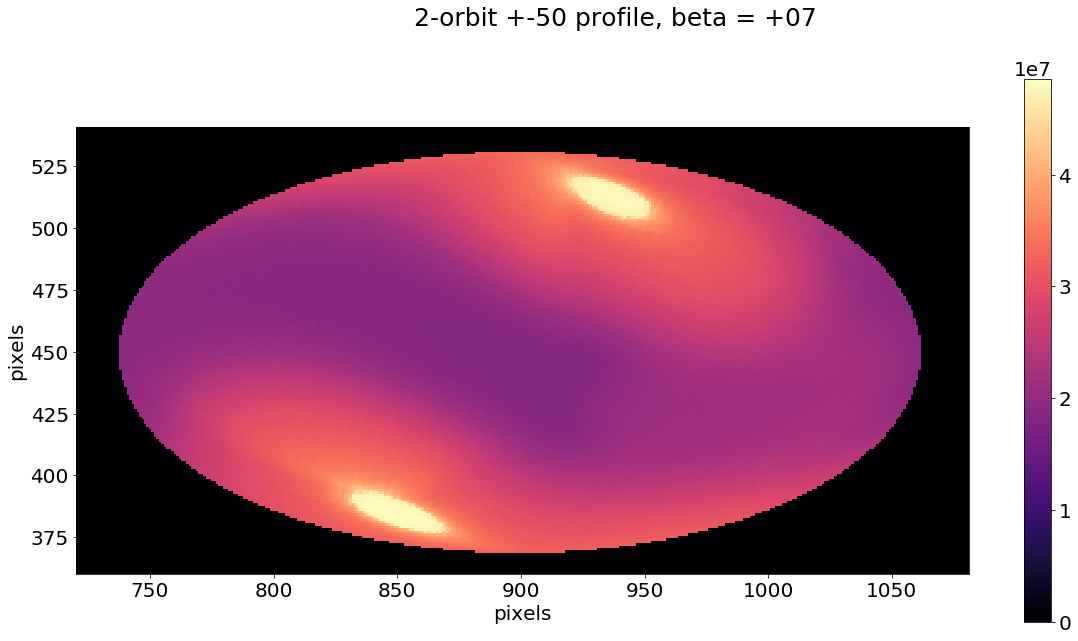

In [71]:
expmap_data = expcube_hdu_2orbit_pm50_bp07[0].data
plt.imshow(expmap_data, cmap='magma')
plt.xlabel('pixels', fontsize=20)
plt.ylabel('pixels', fontsize=20)
plt.xlim(720, 1081)
plt.ylim(360,541)
plt.rcParams['figure.figsize'] = [20, 10]
plt.colorbar()
plt.suptitle('2-orbit +-50 profile, beta = +07', fontsize=25)

Total number of pixels: 41252
Total number of zero-value pixels: 0
Fraction of sky with zero coverage: 0.0
Fraction sky exposed: 1.0


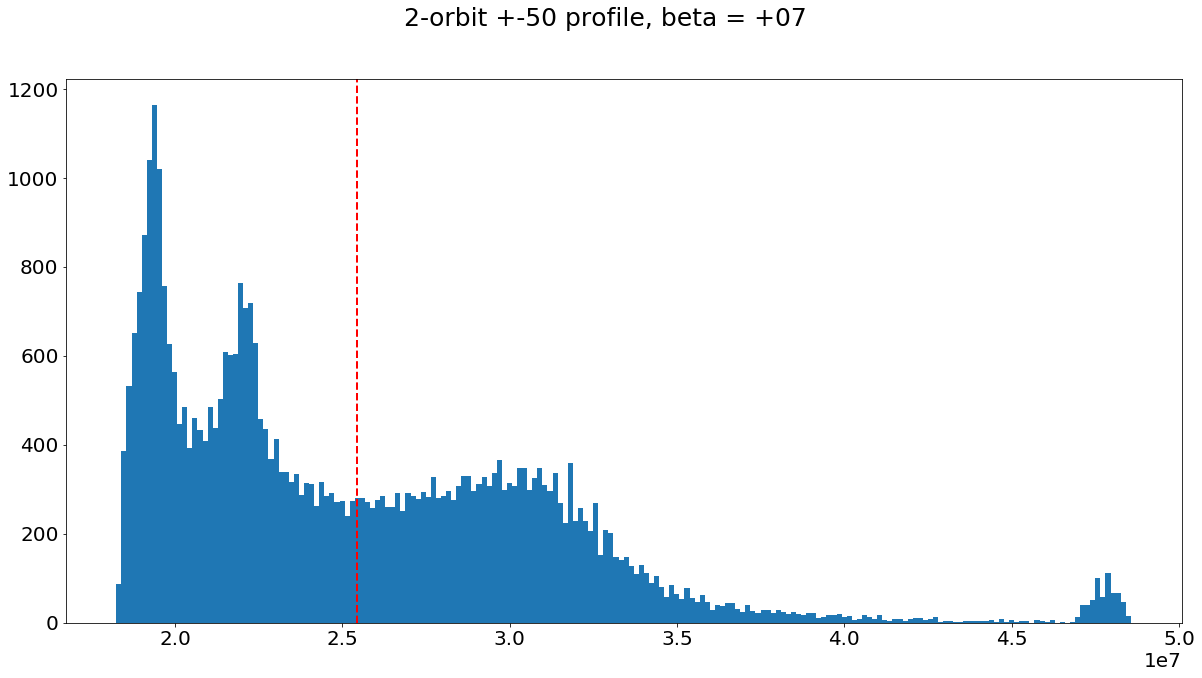

In [73]:
hist_data = expcube_hdu_2orbit_pm50_bp07[0].data[selection].flatten()
print 'Total number of pixels:',len(hist_data)
num_zeros = (hist_data < 1).sum()
print 'Total number of zero-value pixels:',num_zeros
zero_fraction = float((num_zeros)/float(len(hist_data)))
print "Fraction of sky with zero coverage: "+str(zero_fraction)
print('Fraction sky exposed: ' + repr(float(np.count_nonzero(nonzero_2orbit_pm50_bp07))/float(np.count_nonzero(nonzero))))
plt.axvline(x=mean_2orbit_pm50_bp07, color='red', linewidth=2, linestyle='--')
# NOTE: all symmetric rocking profiles will be "fully exposed" over the whole sky, so we don't need the mean*0.5 line
#plt.axvline(x=mean_2orbit_pm50_bp07/2, color='magenta', linewidth=2, linestyle=':')
plt.suptitle('2-orbit +-50 profile, beta = +07', fontsize=25)
plt.hist(hist_data, NBINS)
plt.show()

Text(0.5,0.98,u'2-orbit +-50 profile, beta = +12')

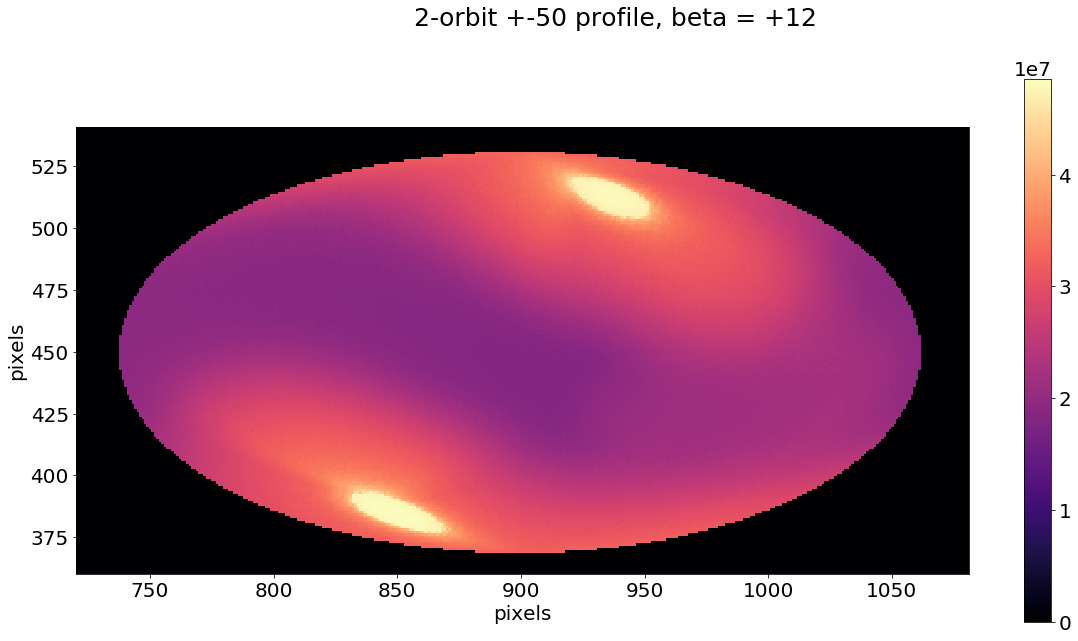

In [72]:
expmap_data = expcube_hdu_2orbit_pm50_bp07[0].data
plt.imshow(expmap_data, cmap='magma')
plt.xlabel('pixels', fontsize=20)
plt.ylabel('pixels', fontsize=20)
plt.xlim(720, 1081)
plt.ylim(360,541)
plt.rcParams['figure.figsize'] = [20, 10]
plt.colorbar()
plt.suptitle('2-orbit +-50 profile, beta = +12', fontsize=25)

Total number of pixels: 41252
Total number of zero-value pixels: 0
Fraction of sky with zero coverage: 0.0
Fraction sky exposed: 1.0
2.54373e+07


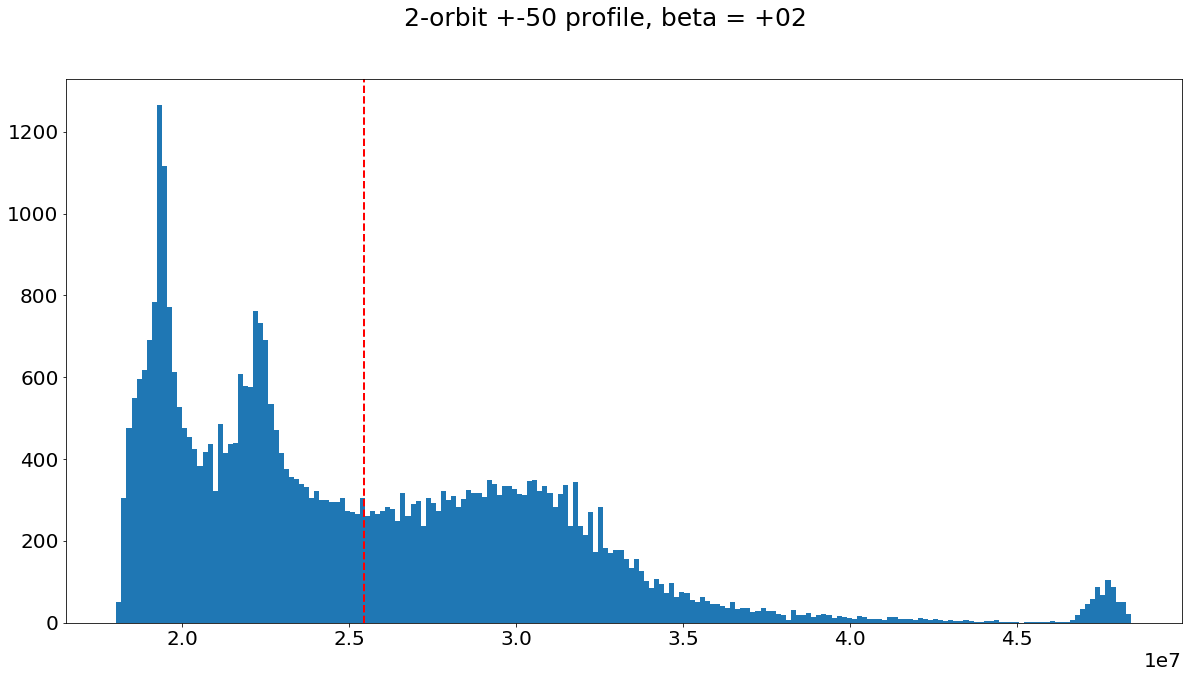

In [17]:
hist_data = expcube_hdu_2orbit_pm50_bp02[0].data[selection].flatten()
print 'Total number of pixels:',len(hist_data)
num_zeros = (hist_data < 1).sum()
print 'Total number of zero-value pixels:',num_zeros
zero_fraction = float((num_zeros)/float(len(hist_data)))
print "Fraction of sky with zero coverage: "+str(zero_fraction)
print('Fraction sky exposed: ' + repr(float(np.count_nonzero(nonzero_2orbit_pm50_bp02))/float(np.count_nonzero(nonzero))))
print mean_2orbit_pm50_bp02
plt.axvline(x=mean_2orbit_pm50_bp02, color='red', linewidth=2, linestyle='--')
#plt.axvline(x=mean_2orbit_pm50_bp02/2, color='magenta', linewidth=2, linestyle=':')
plt.suptitle('2-orbit +-50 profile, beta = +02', fontsize=25)
plt.hist(hist_data, NBINS)
plt.show()